# Community detection in large open-source projects

In [1]:
import networkx as nx
import numpy as np
from IPython.display import SVG, display, Image
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import os

from sklearn.linear_model import LinearRegression

from db.session import connect
from db.models import Request, Review, Comment, User
from network import get_graph
from statistics import mean


In [2]:
%load_ext dotenv
%dotenv

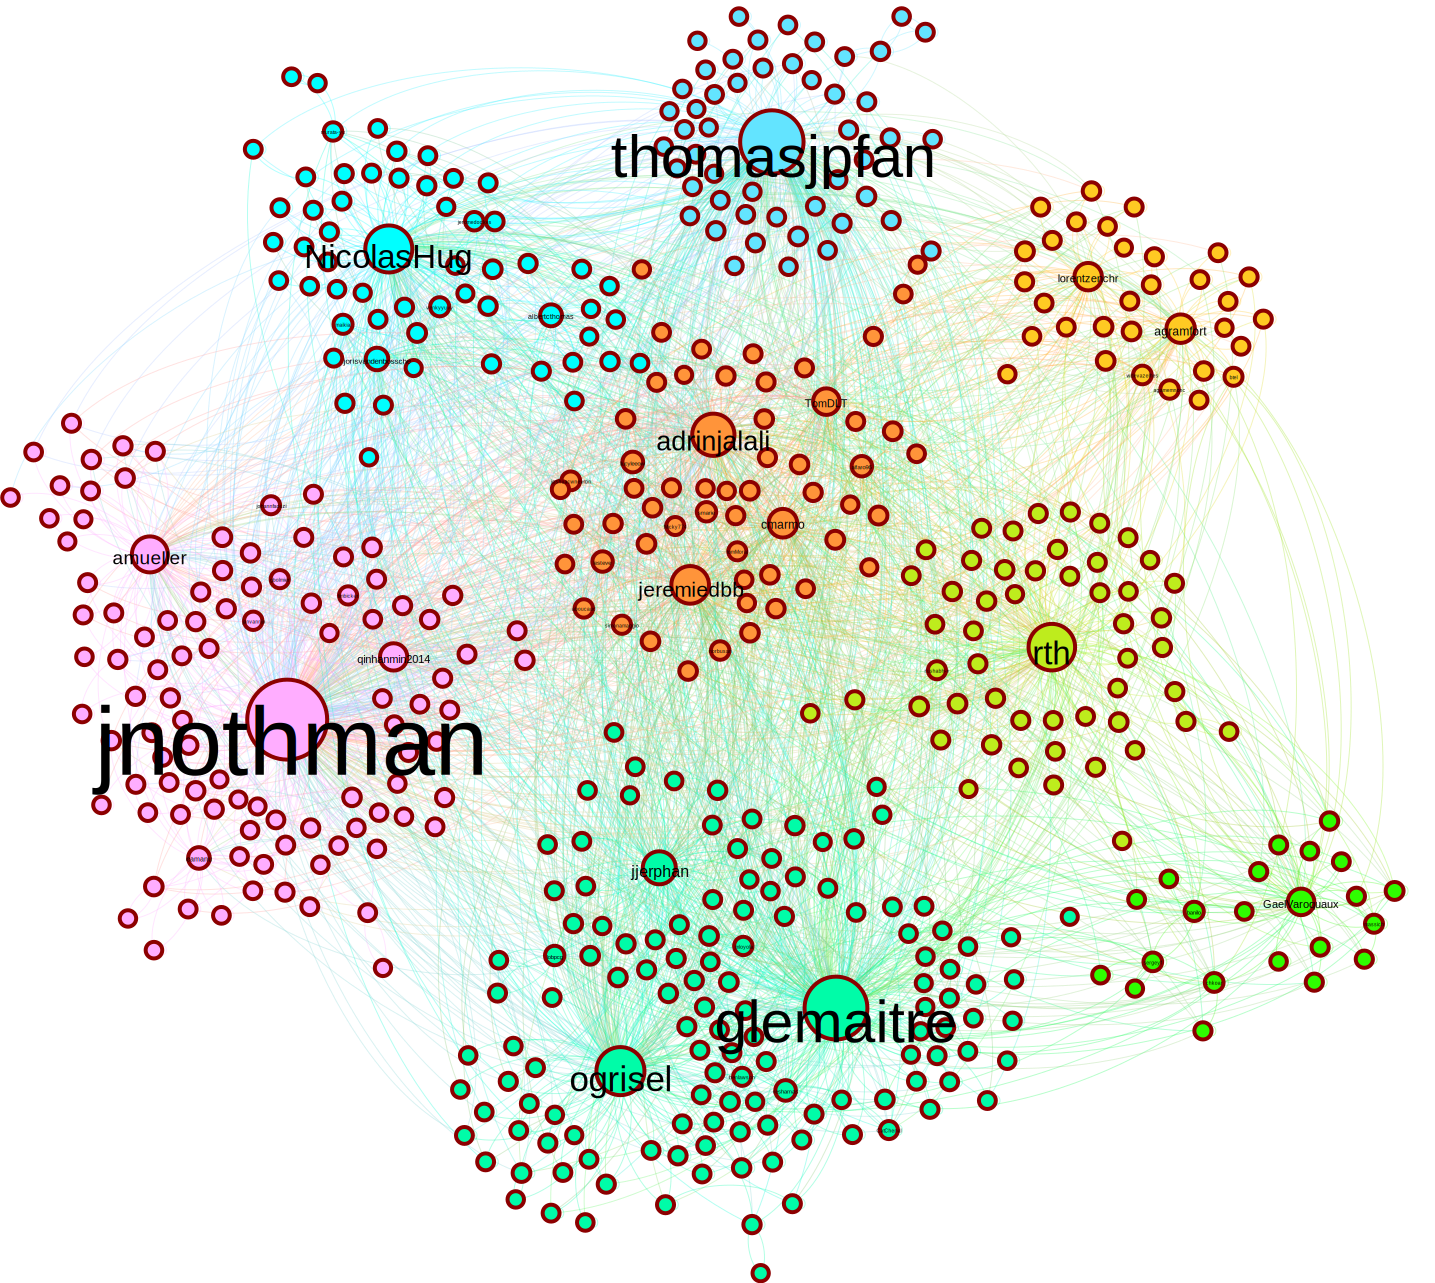

In [3]:
display(SVG(filename='./scikit_graph.svg'))

## Prerequisites

1. Install requirements

In [4]:
# !pip install -r requirements.txt

2. You also need a [PostgreSQL](https://www.postgresql.org/download/) database instance if you want to parse your own copy of the dataset
3. And a GitHub account with a [GitHub token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)

## Data

The dataset used in the project is composed of Pull Requests from scikit-learn repository and associated communication between reviewers and authors.

Data was collected from [Pull Requests in scikit-learn repository](https://github.com/scikit-learn/scikit-learn/pulls?q=is%3Apr+is%3Aopen+comments%3A%3E20) using [GitHub GraphQL API](https://docs.github.com/en/graphql).

### Database

All data is stored in PostgreSQL database using SQLAlchemy ORM. To initialize database run following command:

In [5]:
# !python -m db -c <your connection string>

### Parsing

To parse pull requests:

In [6]:
# !python -m parse -c <your connection string> -t <your GitHub token> -o scikit-learn -r scikit-learn

### Data overview

In [7]:
Session = connect(os.getenv('PG_CONN'))

In [8]:
print('Number of pull requests: {0}'.format(Session.query(Request).count()))

Number of pull requests: 990


In [9]:
print('Number of reviews: {0}'.format(Session.query(Review).count()))

Number of reviews: 18905


In [10]:
print('Number of comments: {0}'.format(Session.query(Comment).count()))

Number of comments: 29077


In [11]:
print('Number of contributors: {0}'.format(Session.query(User).count()))

Number of contributors: 509


## Network analysis

### Summary

Since this is a communication network, the resulting graph is a directional homogeneous unweighted graph with self loops.
All nodes are collaborators to scikit-learn repository.
Edges represent communication between them.

In [12]:
g = get_graph()

# leave only the gigantic component
gcc = sorted([c for c in nx.connected_components(g.to_undirected())], key=lambda x: len(x), reverse=True)[0]

g = g.subgraph(gcc)

# Convert to undirected graph for some calculations
g_u = g.to_undirected()

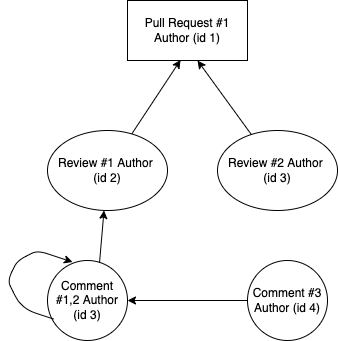

In [13]:
display(Image(filename='communication_diagram.png'))

For example, the diagram above will result in following graph:

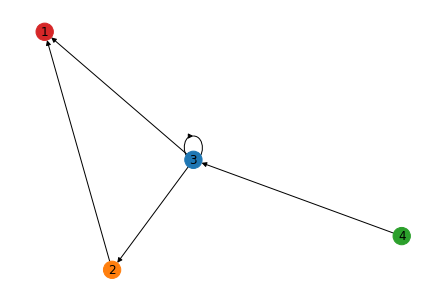

In [14]:
dg = nx.DiGraph()

dg.add_nodes_from(range(1, 5))
dg.add_edges_from([(3, 1), (2, 1), (4, 3), (3, 3), (3, 2)])

node_color = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']

nx.draw(dg, with_labels=True, node_color=node_color)

In [15]:
print('Number of nodes: ', g.number_of_nodes())

Number of nodes:  503


In [16]:
print('Number of edges: ', g.number_of_edges())

Number of edges:  3182


In [17]:
print('Diameter: ', nx.diameter(g_u))

Diameter:  6


In [18]:
print('Radius: ', nx.radius(g_u))

Radius:  3


In [19]:
print('Average clustering coefficient: %.5f' % nx.average_clustering(g_u))

Average clustering coefficient: 0.76663


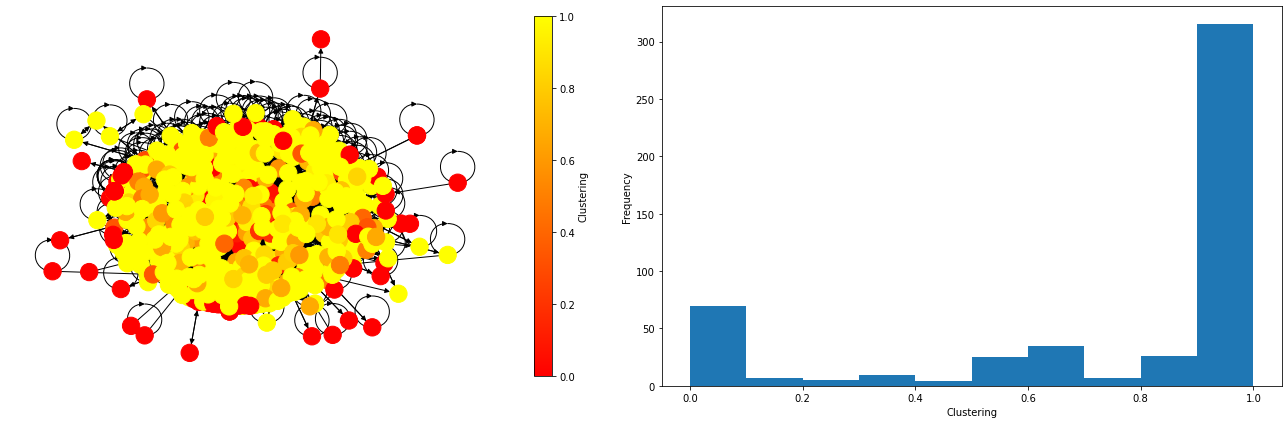

In [20]:
# Based on https://stackoverflow.com/a/64491257

lcc = nx.clustering(g_u)

cmap = plt.get_cmap('autumn')
norm = plt.Normalize(0, max(lcc.values()))
node_colors = [cmap(norm(lcc[node])) for node in g.nodes]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
nx.draw_kamada_kawai(g, node_color=node_colors, with_labels=False, ax=ax1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering', shrink=0.95, ax=ax1)

ax2.hist(lcc.values(), bins=10)
ax2.set_xlabel('Clustering')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [21]:
print('Average path length: %.5f' % nx.average_shortest_path_length(g_u))

Average path length: 2.48334


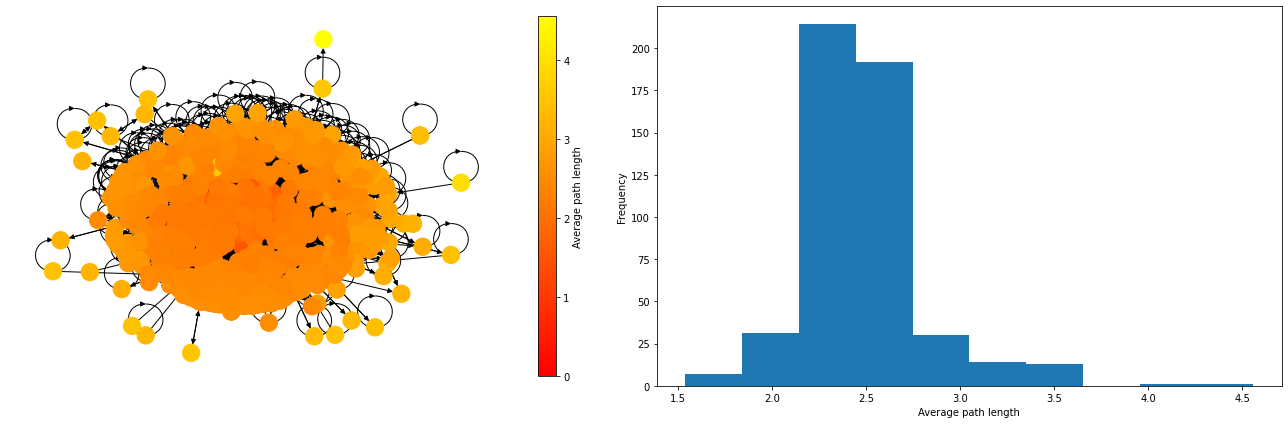

In [22]:
spl = dict(nx.shortest_path_length(g_u))

apl = {}

for source, targets in spl.items():
    apl[source] = mean(targets.values())

cmap = plt.get_cmap('autumn')
norm = plt.Normalize(0, max(apl.values()))
node_colors = [cmap(norm(apl[node])) for node in g.nodes]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
nx.draw_kamada_kawai(g, node_color=node_colors, with_labels=False, ax=ax1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Average path length', shrink=0.95, ax=ax1)

ax2.hist(apl.values(), bins=10)
ax2.set_xlabel('Average path length')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

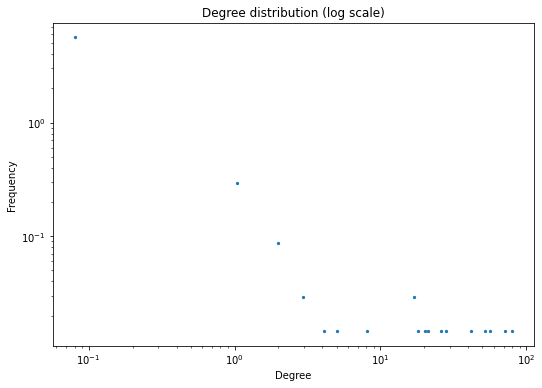

In [23]:
hist, bin_edges = np.histogram(nx.degree_histogram(g), bins=500, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Degree distribution (log scale)')

plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.gcf().set_size_inches(8, 6)
plt.show()


Fit linear regression model

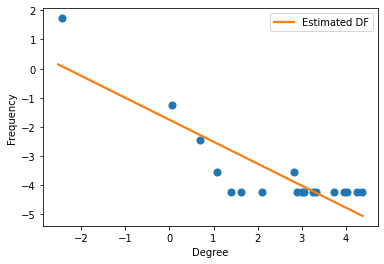

In [63]:
import seaborn as sns

#create scatterplot with regression line
hist, bin_edges = np.histogram(nx.degree_histogram(g), bins=500, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_centers = bin_centers[hist > 0]
hist = hist[hist > 0]

sns.regplot(x=np.log(bin_centers), y=np.log(hist), ci=None, x_bins=500, line_kws={'color': 'tab:orange', 'label': 'Estimated DF'})
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.show()

In [72]:
nx.pagerank(g)

{'lorentzenchr': 0.008806429916373244,
 'ogrisel': 0.024718149409162934,
 'agramfort': 0.009150215414281099,
 'JihaneBennis': 0.0015442836572246328,
 'jeremiedbb': 0.01744774412852348,
 'jjerphan': 0.014891374018720423,
 'adrinjalali': 0.021585518544706094,
 'thomasjpfan': 0.04542759005742962,
 'jnothman': 0.0641334717436365,
 'ArturoAmorQ': 0.0013531398279982444,
 'Micky774': 0.0016258140284672899,
 'glemaitre': 0.03471336483809542,
 'JSchuerz': 0.0011709648013978596,
 'cmarmo': 0.008821201026940267,
 'rgommers': 0.0012368740465941918,
 'TomDLT': 0.007690969627163703,
 'mariokostelac': 0.0010340751346551002,
 'xiaowei1234': 0.0012602049954661687,
 'MaxwellLZH': 0.0017924902102674104,
 'Valavanca': 0.0008616923606075541,
 'lesteve': 0.0030995009524380254,
 'jmloyola': 0.0016664556937889857,
 'NikolayXHD': 0.0008616923606075541,
 'purna135': 0.0007573898483757667,
 'Tenavi': 0.0009974643392377882,
 'zachmayer': 0.001243116459826861,
 'genvalen': 0.001261649489177005,
 'ohadmich': 0.0009